In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from numba import njit
import scipy.interpolate
import scipy.optimize
import os
import lmfit
from tqdm import tqdm
import datetime
from brokenaxes import brokenaxes

from matplotlib import gridspec

import fit_functions
import nekhoroshev_tools

In [3]:
def mm_to_sigma(mm):
    return mm / (0.200 * np.sqrt(4.0 / 3.5))


def scale_factor(vals, sigma_barrier):
    return vals / 1.8e-11


def get_roi(df, from_t, to_t):
    return df[(df["t"] >= from_t) & (df["t"] <= to_t)]

In [4]:
# read csv file
loss_1_rs9 = pd.read_csv("timber2/BLMTI.06L7.B1E10_TCP.D6L7.B1_LOSS_RS09.csv", header=1)
loss_1_rs6 = pd.read_csv("timber2/BLMTI.06L7.B1E10_TCP.D6L7.B1_LOSS_RS06.csv", header=1)
loss_1_rs4 = pd.read_csv("timber2/BLMTI.06L7.B1E10_TCP.D6L7.B1_LOSS_RS04.csv", header=1)

loss_2_rs9 = pd.read_csv("timber/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS09.csv", header=1)
loss_2_rs6 = pd.read_csv("timber/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS06.csv", header=1)
loss_2_rs4 = pd.read_csv("timber/BLMTI.06L7.B1E10_TCP.C6L7.B1_LOSS_RS04.csv", header=1)

barrier = pd.read_csv("timber/TCP.D6L7.B1_MEAS_LVDT_LU.csv", header=1)
barrier["Value"] = mm_to_sigma(barrier["Value"])

barrier2 = pd.read_csv("timber2/TCP.C6L7.B1_MEAS_LVDT_LU.csv", header=1)
barrier2["Value"] = mm_to_sigma(barrier2["Value"])

In [5]:
# read csv file
b2_loss_1_rs9 = pd.read_csv("timber_b2/BLMTI.06R7.B2I10_TCP.C6R7.B2_LOSS_RS09.csv", header=1)
b2_loss_1_rs6 = pd.read_csv("timber_b2/BLMTI.06R7.B2I10_TCP.C6R7.B2_LOSS_RS06.csv", header=1)
b2_loss_1_rs4 = pd.read_csv("timber_b2/BLMTI.06R7.B2I10_TCP.C6R7.B2_LOSS_RS04.csv", header=1)

b2_loss_2_rs9 = pd.read_csv("timber2_b2/BLMTI.06R7.B2I10_TCP.D6R7.B2_LOSS_RS09.csv", header=1)
b2_loss_2_rs6 = pd.read_csv("timber2_b2/BLMTI.06R7.B2I10_TCP.D6R7.B2_LOSS_RS06.csv", header=1)
b2_loss_2_rs4 = pd.read_csv("timber2_b2/BLMTI.06R7.B2I10_TCP.D6R7.B2_LOSS_RS04.csv", header=1)

b2_barrier = pd.read_csv("timber_b2/TCP.D6R7.B2_MEAS_LVDT_LU.csv", header=1)
b2_barrier["Value"] = mm_to_sigma(b2_barrier["Value"])

b2_barrier2 = pd.read_csv("timber2_b2/TCP.C6R7.B2_MEAS_LVDT_LU.csv", header=1)
b2_barrier2["Value"] = mm_to_sigma(b2_barrier2["Value"])

In [6]:
def utc_time_to_seconds(df):
    df["t"] = df["Timestamp (UTC_TIME)"].apply(
        lambda x: (
            datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f") - datetime.datetime.strptime(loss_1_rs9["Timestamp (UTC_TIME)"].iloc[0], "%Y-%m-%d %H:%M:%S.%f")).total_seconds()
    )
    return df

In [7]:
def utc_time_to_datetime(df):
    df["datetime"] = df["Timestamp (UTC_TIME)"].apply(
        lambda x: (datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S.%f"))
    )
    return df

In [8]:
loss_1_rs9 = utc_time_to_seconds(loss_1_rs9)
loss_1_rs6 = utc_time_to_seconds(loss_1_rs6)
loss_1_rs4 = utc_time_to_seconds(loss_1_rs4)
loss_2_rs9 = utc_time_to_seconds(loss_2_rs9)
loss_2_rs6 = utc_time_to_seconds(loss_2_rs6)
loss_2_rs4 = utc_time_to_seconds(loss_2_rs4)

barrier = utc_time_to_seconds(barrier)
barrier2 = utc_time_to_seconds(barrier2)

In [9]:
b2_loss_1_rs9 = utc_time_to_seconds(b2_loss_1_rs9)
b2_loss_1_rs6 = utc_time_to_seconds(b2_loss_1_rs6)
b2_loss_1_rs4 = utc_time_to_seconds(b2_loss_1_rs4)
b2_loss_2_rs9 = utc_time_to_seconds(b2_loss_2_rs9)
b2_loss_2_rs6 = utc_time_to_seconds(b2_loss_2_rs6)
b2_loss_2_rs4 = utc_time_to_seconds(b2_loss_2_rs4)

b2_barrier = utc_time_to_seconds(b2_barrier)
b2_barrier2 = utc_time_to_seconds(b2_barrier2)

In [10]:
loss_1_rs9 = utc_time_to_datetime(loss_1_rs9)
loss_1_rs6 = utc_time_to_datetime(loss_1_rs6)
loss_1_rs4 = utc_time_to_datetime(loss_1_rs4)
loss_2_rs9 = utc_time_to_datetime(loss_2_rs9)
loss_2_rs6 = utc_time_to_datetime(loss_2_rs6)
loss_2_rs4 = utc_time_to_datetime(loss_2_rs4)

barrier = utc_time_to_datetime(barrier)
barrier2 = utc_time_to_datetime(barrier2)

In [11]:
b2_loss_1_rs9 = utc_time_to_datetime(b2_loss_1_rs9)
b2_loss_1_rs6 = utc_time_to_datetime(b2_loss_1_rs6)
b2_loss_1_rs4 = utc_time_to_datetime(b2_loss_1_rs4)
b2_loss_2_rs9 = utc_time_to_datetime(b2_loss_2_rs9)
b2_loss_2_rs6 = utc_time_to_datetime(b2_loss_2_rs6)
b2_loss_2_rs4 = utc_time_to_datetime(b2_loss_2_rs4)

b2_barrier = utc_time_to_datetime(b2_barrier)
b2_barrier2 = utc_time_to_datetime(b2_barrier2)

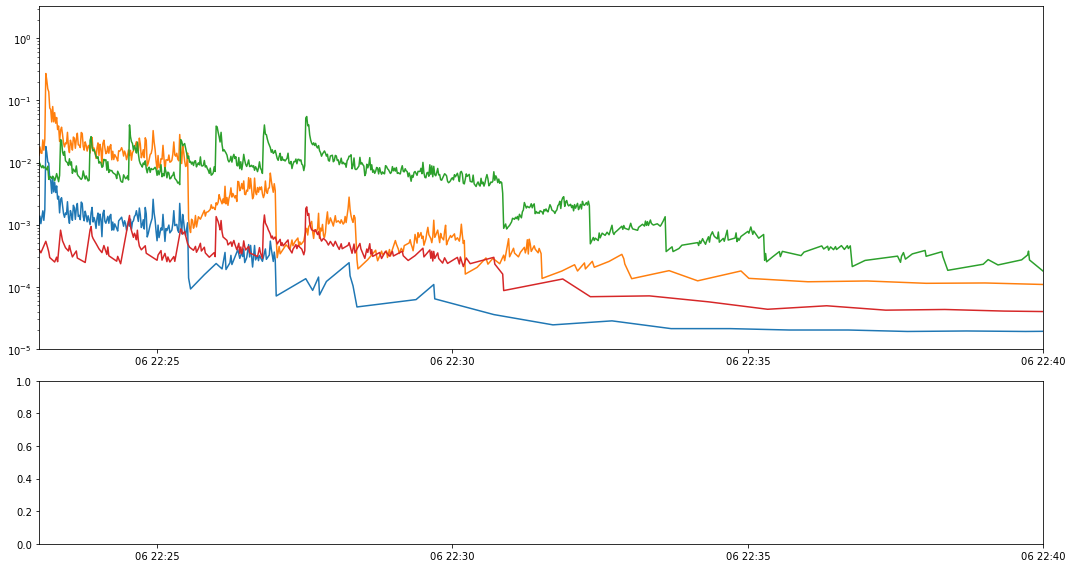

In [46]:
fig = plt.figure(figsize=(15, 8))

gs = gridspec.GridSpec(2, 1, height_ratios=[2.1, 1])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

ax0.plot(loss_1_rs6["datetime"], loss_1_rs6["Value"], label="RS6")
ax0.plot(loss_2_rs6["datetime"], loss_2_rs6["Value"], label="RS6")

ax0.plot(b2_loss_1_rs6["datetime"], b2_loss_1_rs6["Value"], label="RS6")
ax0.plot(b2_loss_2_rs6["datetime"], b2_loss_2_rs6["Value"], label="RS6")

ax0.set_yscale("log")
ax0.set_ylim(1e-5)

# ax1.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

# b_func = scipy.interpolate.interp1d(
#     barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
# )
# ax1.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

# ax1.scatter(barrier2["t"], barrier2["Value"], label="Barrier", color="black")

# b_func = scipy.interpolate.interp1d(
#     barrier2["t"], barrier2["Value"], kind="previous", fill_value="extrapolate"
# )
# ax1.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

# ax1.set_ylim(3.5, 10.0)
ax1.set_xlim(datetime.datetime(2017, 8, 6, 22, 23), datetime.datetime(2017, 8, 6, 22, 40))

plt.tight_layout()
# plt.setp(ax0.get_xticklabels(), visible=False)
# plt.subplots_adjust(hspace=.0)

In [81]:
b2_barrier2

,Timestamp (UTC_TIME),Value,t
0,2017-08-06 05:39:04.876,107.320937,406.876
1,2017-08-06 05:39:14.876,107.299062,416.876
2,2017-08-06 05:58:30.934,107.320937,1572.934
3,2017-08-06 05:58:34.934,107.202812,1576.934
4,2017-08-06 05:59:25.939,107.078125,1627.939
...,...,...,...
2008,2017-08-07 00:13:40.371,NaN,67282.371
2009,2017-08-07 00:13:58.374,NaN,67300.374
2010,2017-08-07 00:14:22.374,NaN,67324.374
2011,2017-08-07 00:14:46.376,NaN,67348.376


In [13]:
roi_1_begin = datetime.datetime(2017, 8, 6, 21, 30)
roi_1_end = datetime.datetime(2017, 8, 6, 22, 5)

roi_2_begin = datetime.datetime(2017, 8, 6, 22, 23)
roi_2_end = datetime.datetime(2017, 8, 6, 22, 40)

In [1]:
pd.date_range(start=roi_1_begin, end=roi_1_end, periods=5)

NameError: name 'pd' is not defined

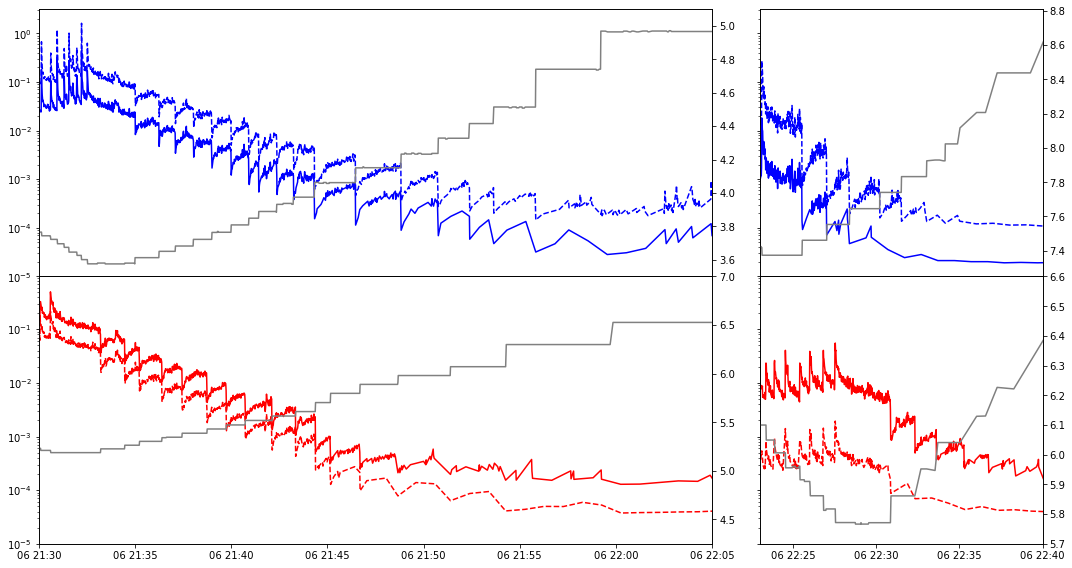

In [12]:
fig = plt.figure(figsize=(15, 8))

gs = gridspec.GridSpec(2, 2, width_ratios=[59250 - 57400, 61425 - 60648])

ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharey=ax0)

ax2 = plt.subplot(gs[2], sharex=ax0)
ax3 = plt.subplot(gs[3], sharey=ax2, sharex=ax1)

ax0_bis = ax0.twinx()
ax1_bis = ax1.twinx()
# ax0_bis.get_shared_y_axes().join(ax0_bis, ax1_bis)
ax2_bis = ax2.twinx()
ax3_bis = ax3.twinx()
# ax2_bis.get_shared_y_axes().join(ax2_bis, ax3_bis)

ax0.plot(loss_1_rs6["datetime"], loss_1_rs6["Value"], label="RS6", color="Blue")
ax0.plot(loss_2_rs6["datetime"], loss_2_rs6["Value"], label="RS6", color="Blue", linestyle="--")

ax2.plot(b2_loss_1_rs6["datetime"], b2_loss_1_rs6["Value"], label="RS6", color="Red")
ax2.plot(b2_loss_2_rs6["datetime"], b2_loss_2_rs6["Value"], label="RS6", color="Red", linestyle="--")

ax1.plot(loss_1_rs6["datetime"], loss_1_rs6["Value"], label="RS6", color="Blue")
ax1.plot(loss_2_rs6["datetime"], loss_2_rs6["Value"], label="RS6", color="Blue", linestyle="--")

ax3.plot(b2_loss_1_rs6["datetime"], b2_loss_1_rs6["Value"], label="RS6", color="Red")
ax3.plot(b2_loss_2_rs6["datetime"], b2_loss_2_rs6["Value"], label="RS6", color="Red", linestyle="--")

ax0.set_yscale("log")
ax0.set_ylim(1e-5)

ax2.set_yscale("log")
ax2.set_ylim(1e-5)

ax0.set_xlim(roi_1_begin, roi_1_end)
ax1.set_xlim(roi_2_begin, roi_2_end)



#ax1_bis.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
ax0_bis.plot(loss_1_rs9["datetime"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")
ax0_bis.set_ylim(3.5, 5.1)

b_func = scipy.interpolate.interp1d(
    barrier2["t"], barrier2["Value"], kind="previous", fill_value="extrapolate"
)
ax1_bis.plot(loss_1_rs9["datetime"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")
ax1_bis.set_ylim(7.25, 8.81)


b_func = scipy.interpolate.interp1d(
    b2_barrier["t"], b2_barrier["Value"], kind="previous", fill_value="extrapolate"
)
ax2_bis.plot(loss_1_rs9["datetime"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")
ax2_bis.set_ylim(4.25, 7.0)

b_func = scipy.interpolate.interp1d(
    b2_barrier2["t"], b2_barrier2["Value"], kind="previous", fill_value="extrapolate"
)
ax3_bis.plot(loss_1_rs9["datetime"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")
ax3_bis.set_ylim(5.7, 6.6)

# ax1.scatter(barrier2["t"], barrier2["Value"], label="Barrier", color="black")

# b_func = scipy.interpolate.interp1d(
#     barrier2["t"], barrier2["Value"], kind="previous", fill_value="extrapolate"
# )
# ax1.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

# ax1.set_ylim(3.5, 10.0)
# ax1.set_xlim(57400, 62025)

plt.tight_layout()
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

plt.setp(ax1.get_yticklabels(), visible=False)
plt.setp(ax3.get_yticklabels(), visible=False)

# plt.setp(ax0_bis.get_yticklabels(), visible=False)
# plt.setp(ax2_bis.get_yticklabels(), visible=False)

plt.subplots_adjust(hspace=.0)
plt.subplots_adjust(wspace=.1)

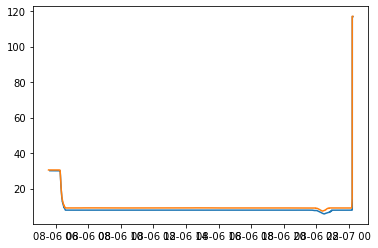

In [96]:
plt.plot(b2_barrier2["datetime"], b2_barrier2["Value"])
plt.plot(barrier2["datetime"], barrier2["Value"])

AttributeError: 'list' object has no attribute 'scatter'

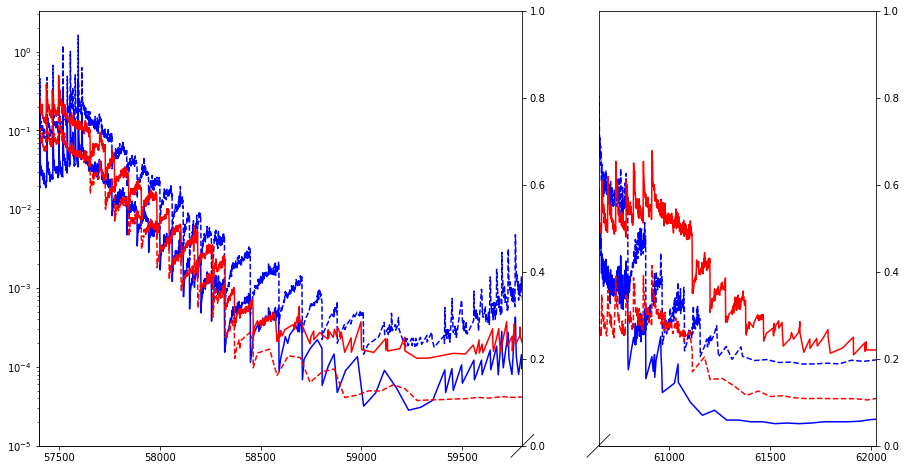

In [23]:
fig = plt.figure(figsize=(15, 8))
#fig, ax0 = plt.subplots(1,1, figsize=(15, 8))
ax0 = brokenaxes(xlims=((57400, 59800), (60648,62025)))
ax1 = ax0.twinx()

ax0.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6", color="Blue")
ax0.plot(loss_2_rs6["t"], loss_2_rs6["Value"], label="RS6", color="Blue", linestyle="--")

ax0.plot(b2_loss_1_rs6["t"], b2_loss_1_rs6["Value"], label="RS6", color="Red")
ax0.plot(b2_loss_2_rs6["t"], b2_loss_2_rs6["Value"], label="RS6", color="Red", linestyle="--")

ax0.set_yscale("log")
ax0.set_ylim(1e-5)

ax1.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
ax1.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

ax1.scatter(barrier2["t"], barrier2["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier2["t"], barrier2["Value"], kind="previous", fill_value="extrapolate"
)
ax1.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

ax1.set_ylim(3.5, 10.0)

plt.tight_layout()
plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)

In [9]:
# ROI 1
roi_1_from_t = 57700.0
roi_1_to_t = 59250.0

In [11]:
loss_1_rs4 = get_roi(loss_1_rs4, roi_1_from_t, roi_1_to_t)
loss_1_rs6 = get_roi(loss_1_rs6, roi_1_from_t, roi_1_to_t)
loss_1_rs9 = get_roi(loss_1_rs9, roi_1_from_t, roi_1_to_t)
loss_2_rs4 = get_roi(loss_2_rs4, roi_1_from_t, roi_1_to_t)
loss_2_rs6 = get_roi(loss_2_rs6, roi_1_from_t, roi_1_to_t)
loss_2_rs9 = get_roi(loss_2_rs9, roi_1_from_t, roi_1_to_t)

barrier = get_roi(barrier, roi_1_from_t, roi_1_to_t)

In [14]:
b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)

def get_idx_vals(df):
    diffs = np.diff(b_func(df["t"]))
    idxs = np.where(diffs > 0.005)[0]
    vals = loss_1_rs9["t"].iloc[np.where(diffs > 0.01)]
    return idxs, vals

In [15]:
idx_loss_1_rs9, vals_loss_1_rs9 = get_idx_vals(loss_1_rs9)
idx_loss_1_rs6, vals_loss_1_rs6 = get_idx_vals(loss_1_rs6)
idx_loss_1_rs4, vals_loss_1_rs4 = get_idx_vals(loss_1_rs4)
idx_loss_2_rs9, vals_loss_2_rs9 = get_idx_vals(loss_2_rs9)
idx_loss_2_rs6, vals_loss_2_rs6 = get_idx_vals(loss_2_rs6)
idx_loss_2_rs4, vals_loss_2_rs4 = get_idx_vals(loss_2_rs4)

(3.5, 5.5)

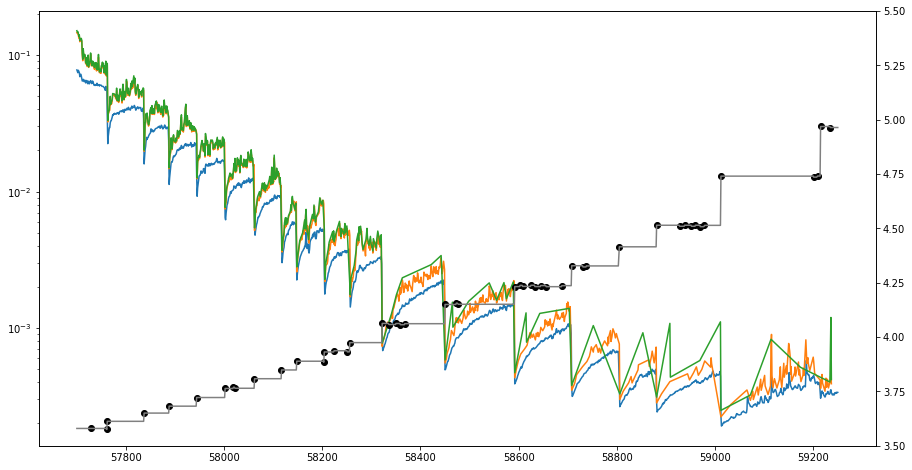

In [13]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs9["t"], loss_1_rs9["Value"], label="RS9")
plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_1_rs4["t"], loss_1_rs4["Value"], label="RS4")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

plt.ylim(3.5, 5.5)

(3.5, 5.5)

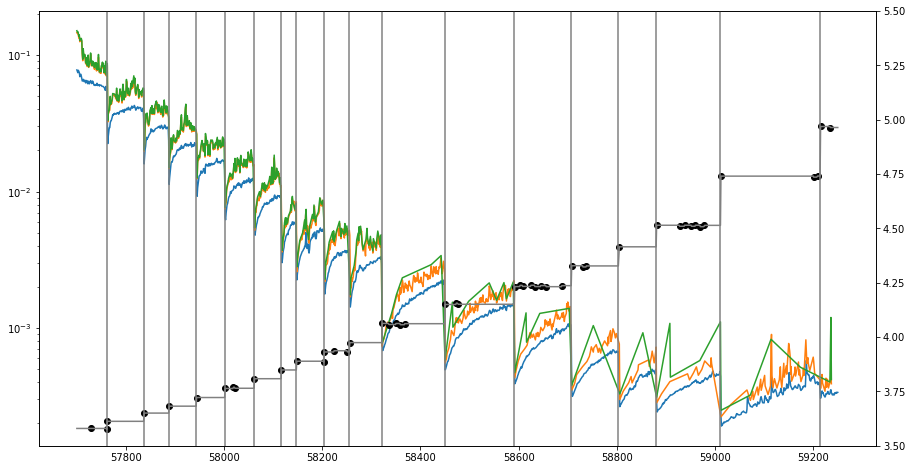

In [16]:
plt.figure(figsize=(15, 8))

plt.plot(loss_1_rs9["t"], loss_1_rs9["Value"], label="RS9")
plt.plot(loss_1_rs6["t"], loss_1_rs6["Value"], label="RS6")
plt.plot(loss_1_rs4["t"], loss_1_rs4["Value"], label="RS4")

plt.yscale("log")

plt.twinx()
plt.scatter(barrier["t"], barrier["Value"], label="Barrier", color="black")

b_func = scipy.interpolate.interp1d(
    barrier["t"], barrier["Value"], kind="previous", fill_value="extrapolate"
)
plt.plot(loss_1_rs9["t"], b_func(loss_1_rs9["t"]), label="Barrier", color="grey")

for v in vals_loss_1_rs9:
    plt.axvline(v, color="grey")

plt.ylim(3.5, 5.5)

In [10]:
# ROI 2
roi_2_from_t = 60648.0
roi_2_to_t = 61425.0